In [1]:
import importlib
import time
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import ndimage

In [2]:
from multi_loc import covariance, assimilate

In [3]:
%matplotlib inline

In [4]:
def imshow(X, title=None, vmin=None, vmax=None, cmap=None):
    plt.figure()
    im = plt.imshow(X, vmin=vmin, vmax=vmax, cmap=cmap)
    plt.colorbar(im)
    plt.title(title)

In [44]:
dimension = 100
rho0_l = 50
rho0_s = 3
dx = 1
H = np.eye(dimension)[::2]
y_size = H.shape[0]

rho = np.arange(dimension, dtype=float)
rho = np.minimum(rho, (dimension - rho) % dimension)
rho = rho*dx

In [45]:
eig_val_l, eig_vec_l, P_l, sort_index = covariance.generate_circulant(
    dimension, dx, rho0_l, covariance.fft_exp_1d,
    return_Corr=True, return_sort_ind=True)
eig_val_l = eig_val_l*(dimension/eig_val_l.sum())
sort_index = np.argsort(sort_index)
eig_val_l = eig_val_l[sort_index]
eig_vec_l = eig_vec_l[:, sort_index]
P_l = eig_vec_l @ np.diag(eig_val_l) @ eig_vec_l.conj().T
P_l = P_l.real
#P_l = P_l/P_l.max()

eig_val_s, eig_vec_s, P_s, sort_index = covariance.generate_circulant(
    dimension, dx, rho0_s, covariance.fft_sqd_exp_1d,
    return_Corr=True, return_sort_ind=True)
eig_val_s = eig_val_s*(dimension/eig_val_s.sum())
sort_index = np.argsort(sort_index)
eig_val_s = eig_val_s[sort_index]
eig_vec_s = eig_vec_s[:, sort_index]
P_s = eig_vec_s @ np.diag(eig_val_s) @ eig_vec_s.conj().T
P_s = P_s.real
#P_s = P_s/P_s.max()

al = 0
eig_val = (1 - al) * eig_val_s + al * eig_val_l
eig_vec = eig_vec_l.copy()

P = eig_vec @ np.diag(eig_val) @ eig_vec.conj().T
eig_val = eig_val * (dimension / eig_val.sum())

sort_index = np.argsort(eig_val)[::-1]
eig_val = eig_val[sort_index]
eig_vec = eig_vec[:, sort_index]

P = eig_vec @ np.diag(eig_val) @ eig_vec.conj().T
P = P.real

sort_index = np.argsort(eig_val_l)[::-1]
eig_val_l = eig_val_l[sort_index]
eig_vec_l = eig_vec_l[:, sort_index]

sort_index = np.argsort(eig_val_s)[::-1]
eig_val_s = eig_val_s[sort_index]
eig_vec_s = eig_vec_s[:, sort_index]


R = np.eye(y_size)

returned = assimilate.transformation_matrices(
    H, eig_val_p=eig_val, eig_vec_p=eig_vec,
    R=R, return_Ts=True)

P_sqrt, P_inv_sqrt = returned[:2]
R_sqrt, R_inv_sqrt = returned[2:4]
U, S, VT = returned[4:7]
Tx, Tx_inv, Ty, Ty_inv = returned[7:]


returned = assimilate.transformation_matrices(
    H, eig_val_p=eig_val_l, eig_vec_p=eig_vec_l,
    R=R, return_Ts=True)

P_sqrt_l, P_inv_sqrt_l = returned[:2]
R_sqrt, R_inv_sqrt = returned[2:4]
U_l, S_l, VT_l = returned[4:7]
Tx_l, Tx_inv_l, Ty_l, Ty_inv_l = returned[7:]

returned = assimilate.transformation_matrices(
    H, eig_val_p=eig_val, eig_vec_p=eig_vec,
    R=R, return_Ts=True)

P_sqrt_s, P_inv_sqrt_s = returned[:2]
R_sqrt, R_inv_sqrt = returned[2:4]
U_s, S_s, VT_s = returned[4:7]
Tx_s, Tx_inv_s, Ty_s, Ty_inv_s = returned[7:]

Log10(condition):  17.083180178313334


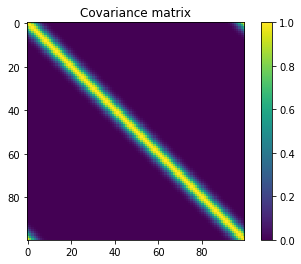

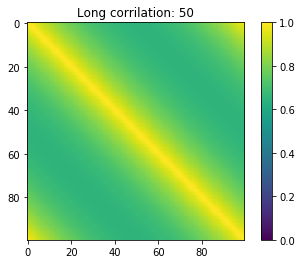

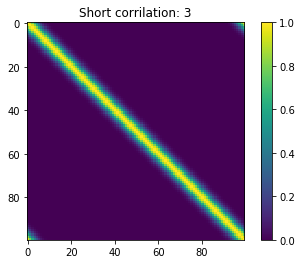

In [46]:
imshow(P, title='Covariance matrix', vmin=0, vmax=1)
imshow(P_l, title=f'Long corrilation: {rho0_l}', vmin=0, vmax=1)
imshow(P_s, title=f'Short corrilation: {rho0_s}', vmin=0, vmax=1)
print('Log10(condition): ',
      np.log10(np.linalg.cond(P)))

Text(0.5,0.98,'Eigenvalues P_s')

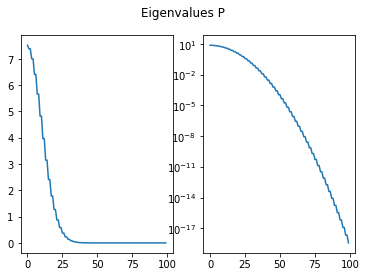

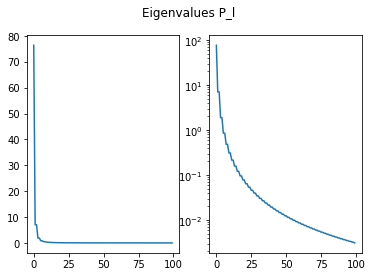

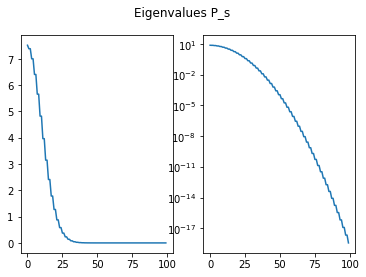

In [47]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(eig_val)
ax[1].semilogy(eig_val)
plt.suptitle('Eigenvalues P')

fig, ax = plt.subplots(1, 2)
ax[0].plot(eig_val_l)
ax[1].semilogy(eig_val_l)
plt.suptitle('Eigenvalues P_l')

fig, ax = plt.subplots(1, 2)
ax[0].plot(eig_val_s)
ax[1].semilogy(eig_val_s)
plt.suptitle('Eigenvalues P_s')

In [55]:
ens_size = 20
obs_size = 100
iterations = 40

In [56]:
mu = np.zeros(dimension)
X_ens = assimilate.generate_ensemble(
    ens_size, mu, P_sqrt)
ground_truth = assimilate.generate_ensemble(
    1, mu, P_sqrt)
Y_ens = H @ ground_truth + R_sqrt @ np.random.randn(y_size, obs_size)

In [57]:
X_ens_p = Tx @ X_ens
Y_ens_p = Ty @ Y_ens

X_ens_p_l = Tx_l @ X_ens
Y_ens_p_l = Ty_l @ Y_ens

X_ens_p_s = Tx_s @ X_ens
Y_ens_p_s = Ty_s @ Y_ens

In [58]:
def plots_t(S, Tx, Tx_inv, Ty_inv, truth, X_ens,
            rmse, rmse_t, y=None, ii=-1):
    plt.figure()
    plt.plot(S @ Tx @ ground_truth, '--')
    plt.plot(S @ X_ens.mean(axis=1), '-')
    if y is not None:
        plt.scatter(np.arange(y_size), y, marker='.')
    plt.legend(['S @ x\'', 'S @ x\' ens mean', 'y\''])
    plt.title(
        f'In transformed space: {ii + 1}'
        + f'; rmse: {rmse_t:0.5}')


    plt.figure()
    plt.plot(ground_truth, '--')
    plt.plot(Tx_inv @ X_ens.mean(axis=1), '-')
    if y is not None:
        plt.scatter(np.arange(dimension)[::2],
                    Ty_inv @ y, marker='.')
    plt.legend(['x', 'x ens mean', 'y'])
    plt.title(f'In real space: {ii + 1}'
              + f'; rmse: {rmse:0.5}')

# Tranformed EnKF

It took:  0.005309466520945231


/Users/harty/anaconda3/envs/multiloc/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Text(0,0.5,'RMSE')

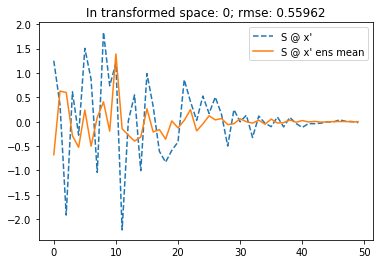

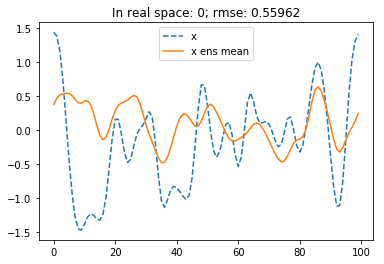

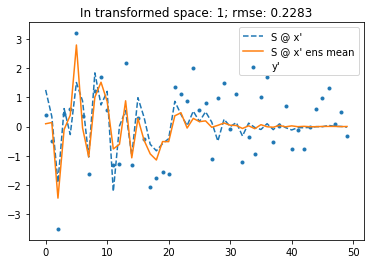

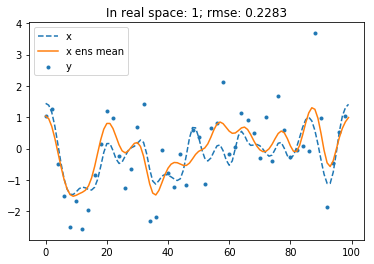

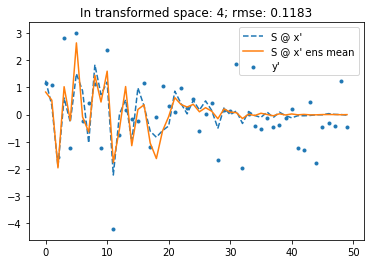

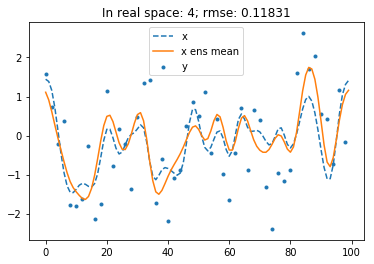

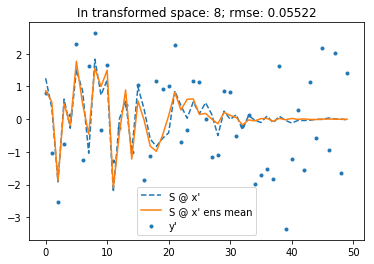

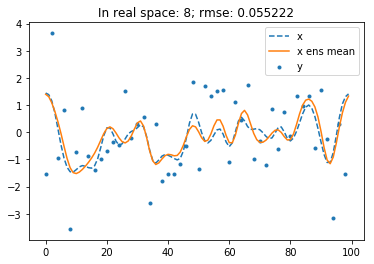

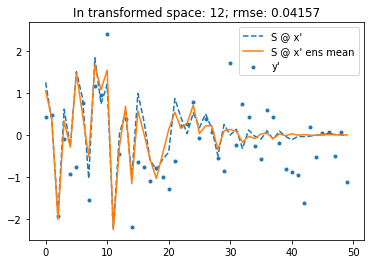

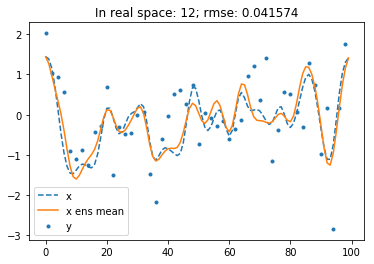

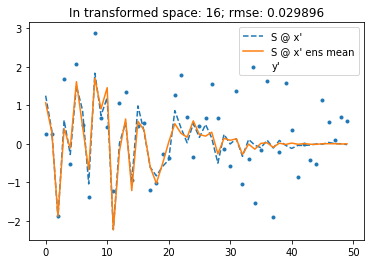

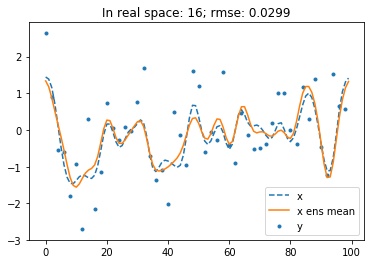

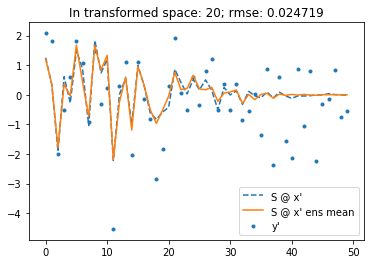

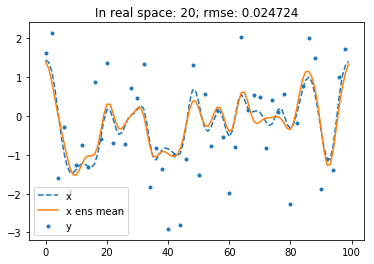

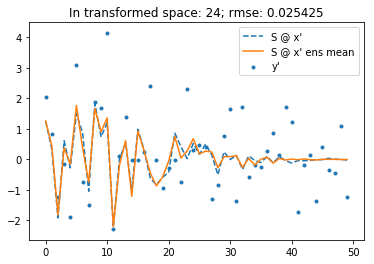

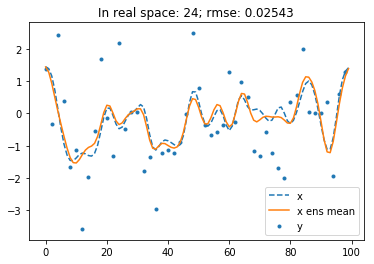

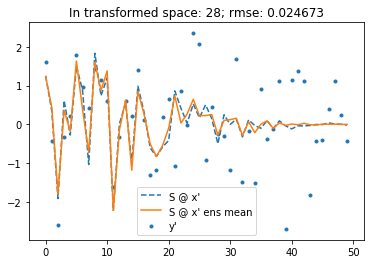

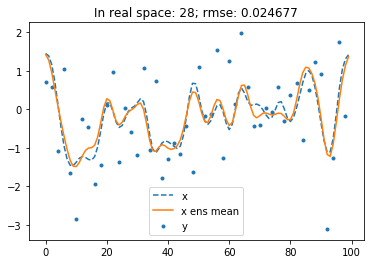

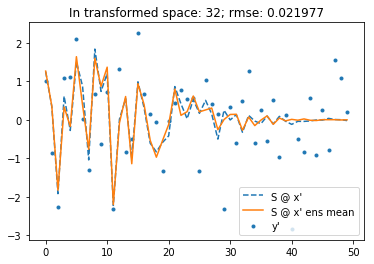

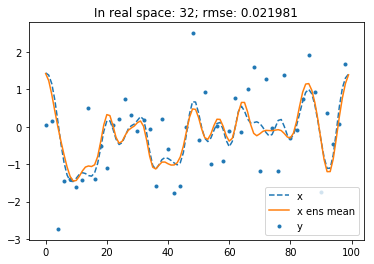

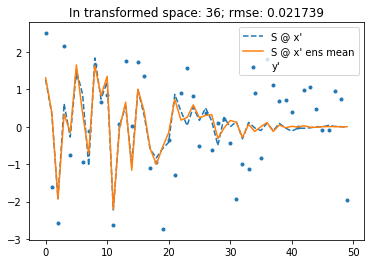

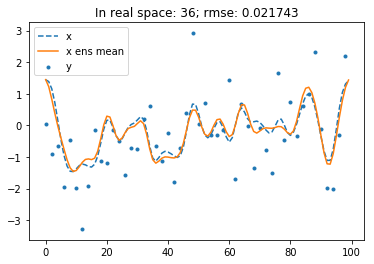

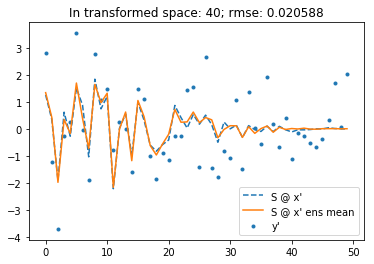

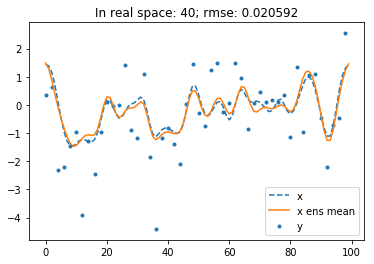

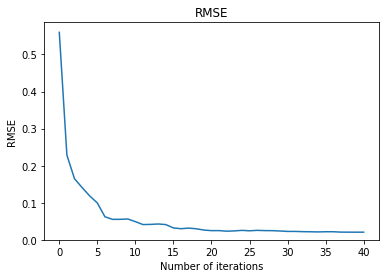

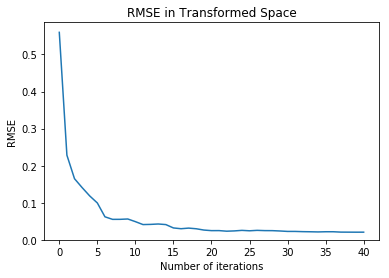

In [59]:
X_ens_kf = X_ens_p.copy()
S_kf_reduced = S.diagonal()[:, None]
P_kf_reduced = np.ones(y_size)[:, None]
I_reduced = np.ones(y_size)[:, None]

rmse = np.ones(iterations + 1)*np.nan
rmse_t = rmse.copy()
error = (ground_truth
         - Tx_inv @ X_ens_kf.mean(axis=1)[:, None])
error_t = (S @ Tx @ ground_truth
           - S @ X_ens_kf.mean(axis=1)[:, None])
rmse[0] = (error**2).mean()
rmse_t[0] = (error_t**2).mean()

plots_t(S, Tx, Tx_inv, Ty_inv,
      ground_truth, X_ens_kf, rmse[0], rmse_t[0])

time0 = time.time()
for ii in range(iterations):
    # mu_p = X_ens_kf.mean(axis=1)[:, None]
    Y_obs = (Y_ens_p[:, ii][:, None] 
             + U.T @ np.random.randn(y_size, ens_size))
    P_kf_reduced = np.var(X_ens_kf[:y_size], axis=1)[:, None]
    K = ((S_kf_reduced * P_kf_reduced)
        / (1 + S_kf_reduced**2 * P_kf_reduced))
    X_ens_kf[:y_size] = (X_ens_kf[:y_size]
                         + K * (Y_obs - S @ X_ens_kf))
    error = (ground_truth
             - Tx_inv @ X_ens_kf.mean(axis=1)[:, None])
    error_t = (S @ Tx @ ground_truth
               - S @ X_ens_kf.mean(axis=1)[:, None])
    rmse[ii + 1] = (error**2).mean()
    rmse_t[ii + 1] = (error_t**2).mean()
    if (ii + 1) % round(iterations/10) == 0 or ii + 1 == 1 :
        plots_t(S, Tx, Tx_inv, Ty_inv,
              ground_truth, X_ens_kf, rmse[ii + 1],
              rmse_t[ii + 1], y=Y_ens_p[:, ii], ii=ii)
time1 = time.time()
elapsed = (time1 - time0)/60
print('It took: ', elapsed)
plt.figure()
plt.plot(rmse)
plt.ylim([0, None])
plt.title('RMSE')
plt.xlabel('Number of iterations')
plt.ylabel('RMSE')

plt.figure()
plt.plot(rmse_t)
plt.ylim([0, None])
plt.title('RMSE in Transformed Space')
plt.xlabel('Number of iterations')
plt.ylabel('RMSE')

# Tranformed EnKF l only

It took:  0.00545039971669515


/Users/harty/anaconda3/envs/multiloc/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Text(0,0.5,'RMSE')

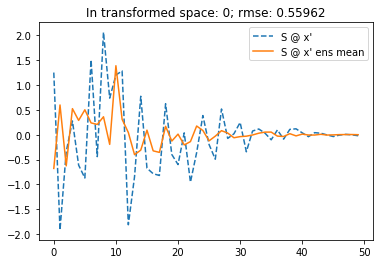

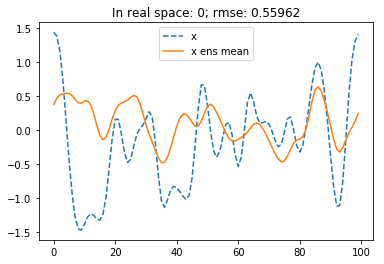

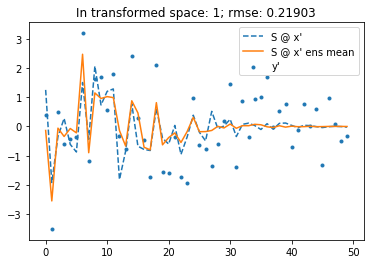

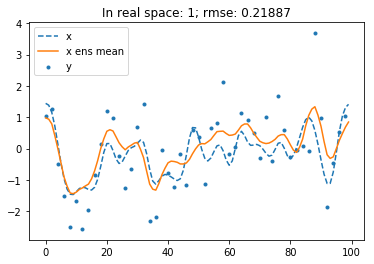

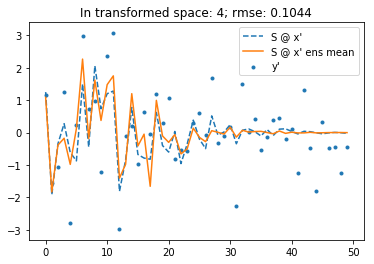

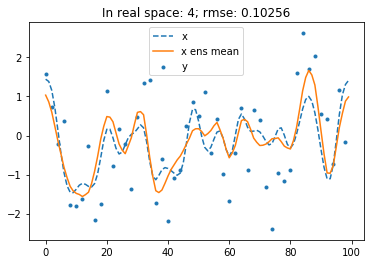

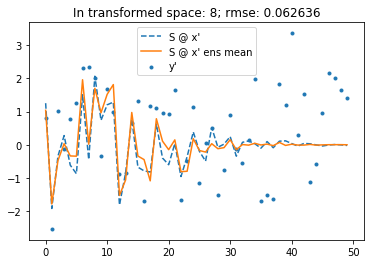

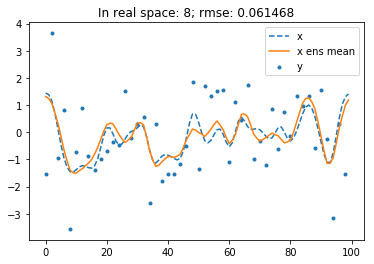

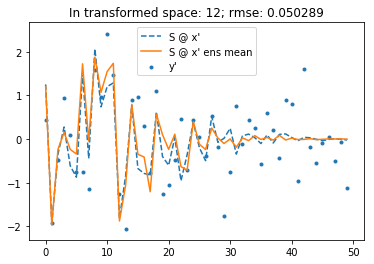

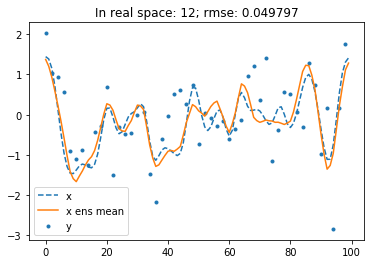

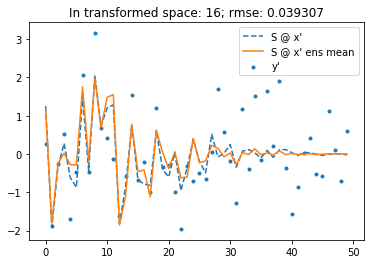

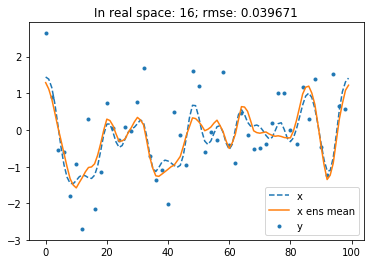

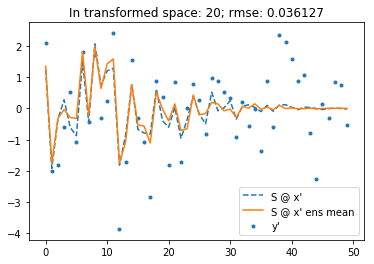

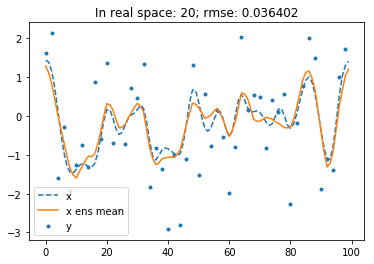

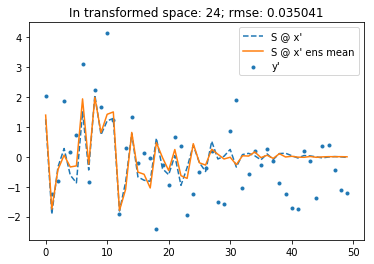

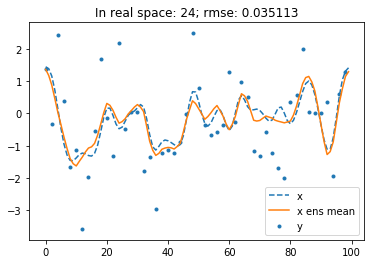

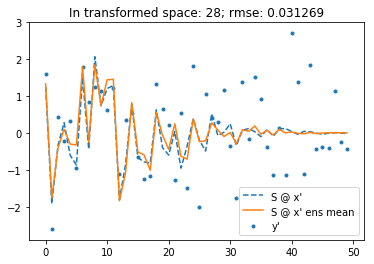

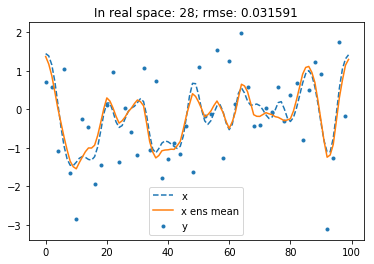

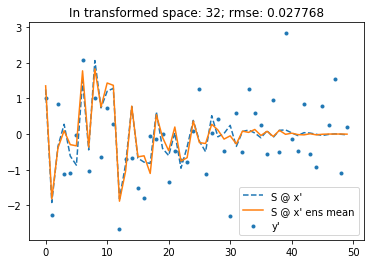

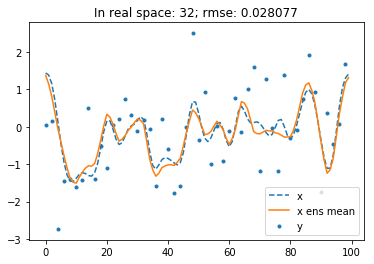

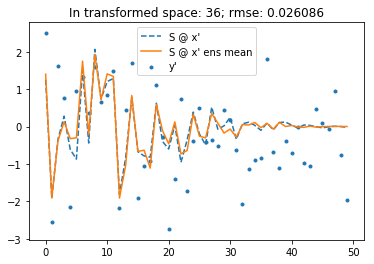

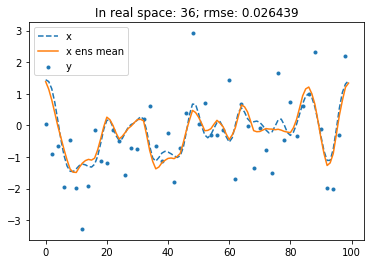

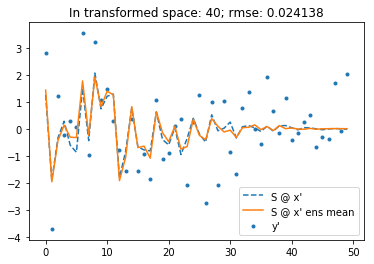

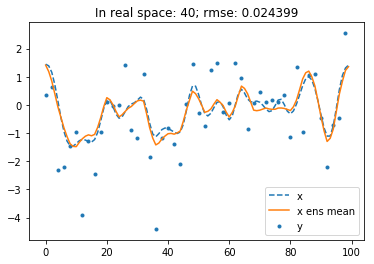

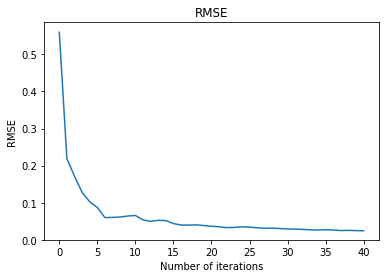

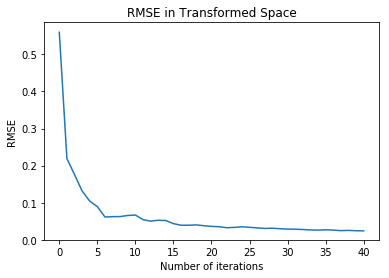

In [60]:
X_ens_kf = X_ens_p_l.copy()
Y_ens_kf = Y_ens_p_l.copy()
S_kf_reduced = S_l.diagonal()[:, None]
P_kf_reduced = np.ones(y_size)[:, None]
I_reduced = np.ones(y_size)[:, None]
Tx_kf = Tx_l.copy()
Ty_kf = Ty_l.copy()
Tx_inv_kf = Tx_inv_l.copy()
Ty_inv_kf = Ty_inv_l.copy()
S_kf = S_l.copy()
U_kf = U_l.copy()

rmse = np.ones(iterations + 1)*np.nan
rmse_t = rmse.copy()
error = (ground_truth
         - Tx_inv_kf @ X_ens_kf.mean(axis=1)[:, None])
error_t = (S_kf @ Tx_kf @ ground_truth
           - S_kf @ X_ens_kf.mean(axis=1)[:, None])
rmse[0] = (error**2).mean()
rmse_t[0] = (error_t**2).mean()

plots_t(S_kf, Tx_kf, Tx_inv_kf, Ty_inv_kf,
      ground_truth, X_ens_kf, rmse[0], rmse_t[0])

time0 = time.time()
for ii in range(iterations):
    # mu_p = X_ens_kf.mean(axis=1)[:, None]
    Y_obs = (Y_ens_kf[:, ii][:, None] 
             + U_kf.T @ np.random.randn(y_size, ens_size))
    P_kf_reduced = np.var(X_ens_kf[:y_size], axis=1)[:, None]
    K = ((S_kf_reduced * P_kf_reduced)
        / (1 + S_kf_reduced**2 * P_kf_reduced))
    X_ens_kf[:y_size] = (X_ens_kf[:y_size]
                         + K * (Y_obs - S_kf @ X_ens_kf))
    error = (ground_truth
             - Tx_inv_kf @ X_ens_kf.mean(axis=1)[:, None])
    error_t = (S_kf @ Tx_kf @ ground_truth
               - S_kf @ X_ens_kf.mean(axis=1)[:, None])
    rmse[ii + 1] = (error**2).mean()
    rmse_t[ii + 1] = (error_t**2).mean()
    if (ii + 1) % round(iterations/10) == 0 or ii + 1 == 1 :
        plots_t(S_kf, Tx_kf, Tx_inv_kf, Ty_inv_kf,
              ground_truth, X_ens_kf, rmse[ii + 1],
              rmse_t[ii + 1], y=Y_ens_kf[:, ii], ii=ii)
time1 = time.time()
elapsed = (time1 - time0)/60
print('It took: ', elapsed)
plt.figure()
plt.plot(rmse)
plt.ylim([0, None])
plt.title('RMSE')
plt.xlabel('Number of iterations')
plt.ylabel('RMSE')

plt.figure()
plt.plot(rmse_t)
plt.ylim([0, None])
plt.title('RMSE in Transformed Space')
plt.xlabel('Number of iterations')
plt.ylabel('RMSE')

# Tranformed EnKF s only

It took:  0.005613752206166585


/Users/harty/anaconda3/envs/multiloc/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Text(0,0.5,'RMSE')

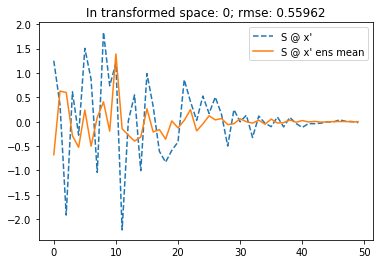

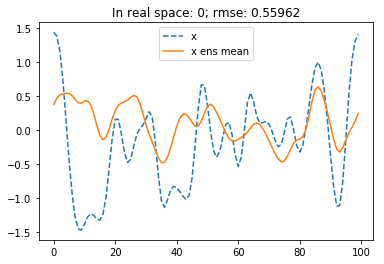

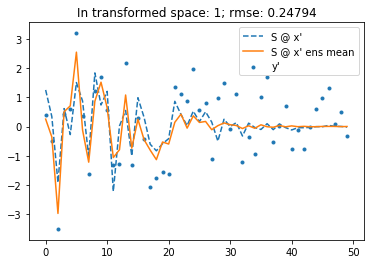

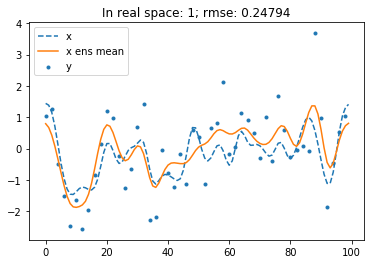

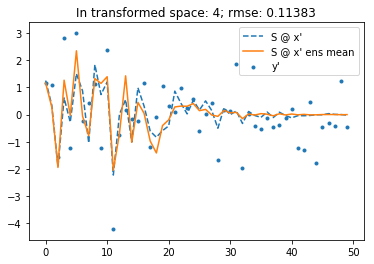

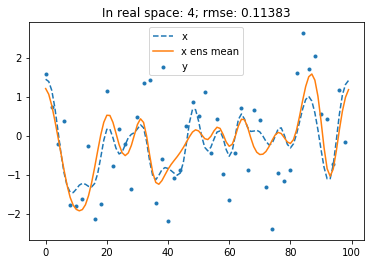

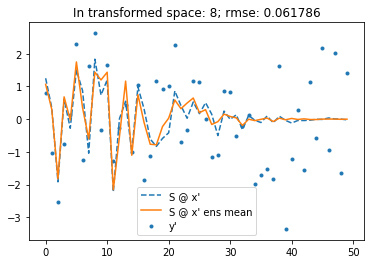

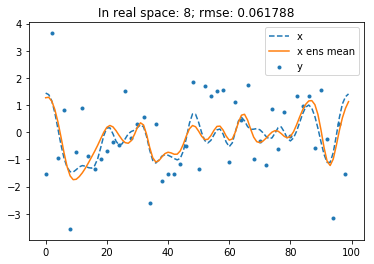

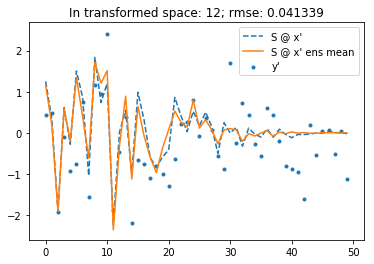

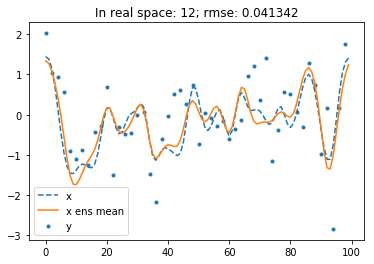

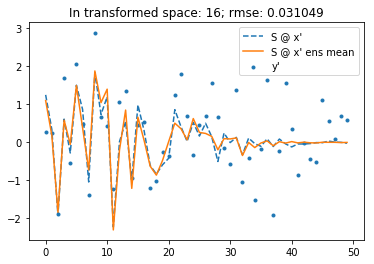

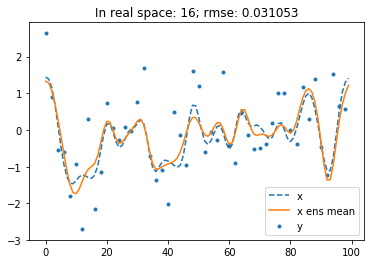

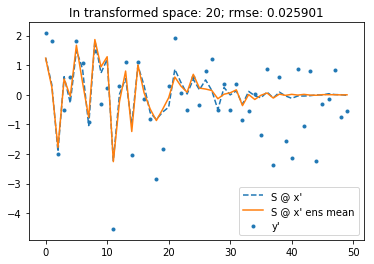

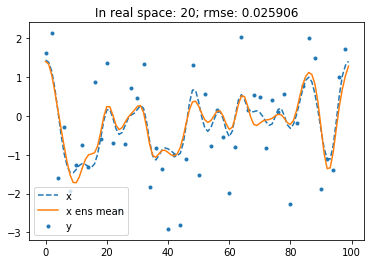

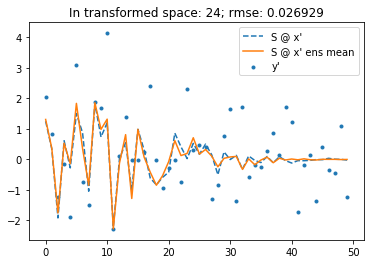

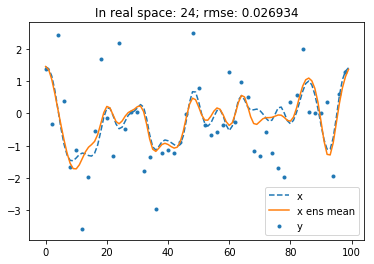

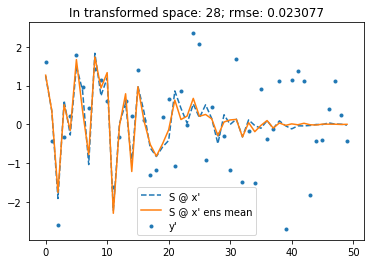

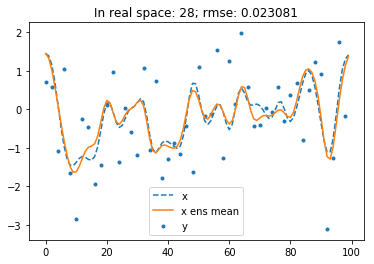

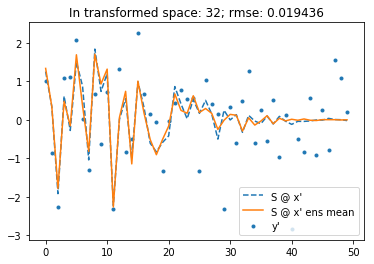

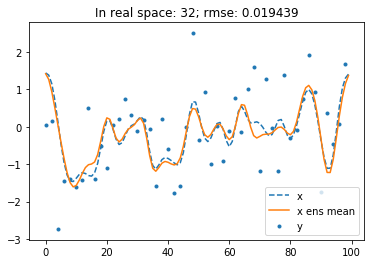

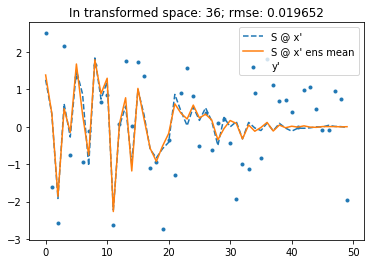

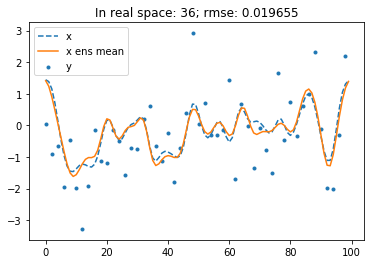

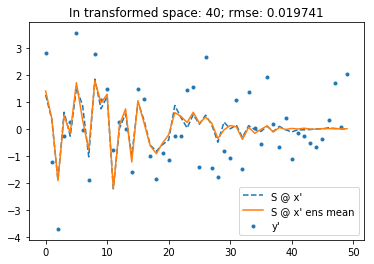

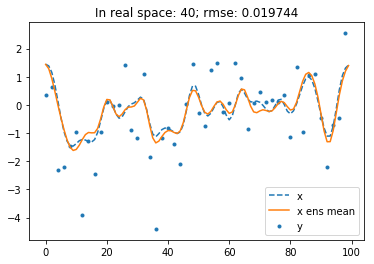

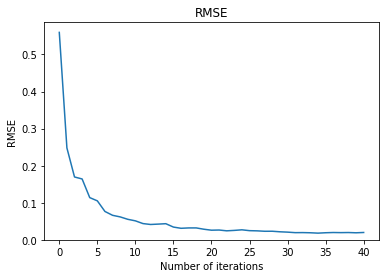

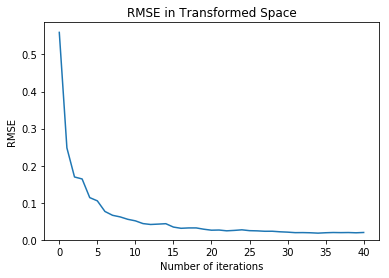

In [61]:
X_ens_kf = X_ens_p_s.copy()
Y_ens_kf = Y_ens_p_s.copy()
S_kf_reduced = S_s.diagonal()[:, None]
P_kf_reduced = np.ones(y_size)[:, None]
I_reduced = np.ones(y_size)[:, None]
Tx_kf = Tx_s.copy()
Ty_kf = Ty_s.copy()
Tx_inv_kf = Tx_inv_s.copy()
Ty_inv_kf = Ty_inv_s.copy()
S_kf = S_s.copy()
U_kf = U_s.copy()

rmse = np.ones(iterations + 1)*np.nan
rmse_t = rmse.copy()
error = (ground_truth
         - Tx_inv_kf @ X_ens_kf.mean(axis=1)[:, None])
error_t = (S_kf @ Tx_kf @ ground_truth
           - S_kf @ X_ens_kf.mean(axis=1)[:, None])
rmse[0] = (error**2).mean()
rmse_t[0] = (error_t**2).mean()

plots_t(S_kf, Tx_kf, Tx_inv_kf, Ty_inv_kf,
      ground_truth, X_ens_kf, rmse[0], rmse_t[0])

time0 = time.time()
for ii in range(iterations):
    # mu_p = X_ens_kf.mean(axis=1)[:, None]
    Y_obs = (Y_ens_kf[:, ii][:, None] 
             + U_kf.T @ np.random.randn(y_size, ens_size))
    P_kf_reduced = np.var(X_ens_kf[:y_size], axis=1)[:, None]
    K = ((S_kf_reduced * P_kf_reduced)
        / (1 + S_kf_reduced**2 * P_kf_reduced))
    X_ens_kf[:y_size] = (X_ens_kf[:y_size]
                         + K * (Y_obs - S_kf @ X_ens_kf))
    error = (ground_truth
             - Tx_inv_kf @ X_ens_kf.mean(axis=1)[:, None])
    error_t = (S_kf @ Tx_kf @ ground_truth
               - S_kf @ X_ens_kf.mean(axis=1)[:, None])
    rmse[ii + 1] = (error**2).mean()
    rmse_t[ii + 1] = (error_t**2).mean()
    if (ii + 1) % round(iterations/10) == 0 or ii + 1 == 1 :
        plots_t(S_kf, Tx_kf, Tx_inv_kf, Ty_inv_kf,
              ground_truth, X_ens_kf, rmse[ii + 1],
              rmse_t[ii + 1], y=Y_ens_kf[:, ii], ii=ii)
time1 = time.time()
elapsed = (time1 - time0)/60
print('It took: ', elapsed)
plt.figure()
plt.plot(rmse)
plt.ylim([0, None])
plt.title('RMSE')
plt.xlabel('Number of iterations')
plt.ylabel('RMSE')

plt.figure()
plt.plot(rmse_t)
plt.ylim([0, None])
plt.title('RMSE in Transformed Space')
plt.xlabel('Number of iterations')
plt.ylabel('RMSE')